In [2]:
# === WHY THIS MATTERS: SETTING UP THE PROJECT ENVIRONMENT ===
# Technical: These imports enable you to process data, build models, save results, and create visuals.
# Layman: These are the Python tools that let us read spreadsheet data, make predictions, and create easy-to-share charts.

import os  # For handling file locations and folders
import pandas as pd  # For spreadsheet/table data
import numpy as np  # For mathematical and statistical calculations
import joblib  # For saving and loading trained models—makes work reusable

# Machine learning tools for preparing and training predictive models
from sklearn.model_selection import train_test_split, TimeSeriesSplit
from sklearn.ensemble import HistGradientBoostingRegressor  # Advanced model for numerical prediction
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score  # To measure accuracy
from sklearn.impute import SimpleImputer  # Fill in blanks automatically
from sklearn.preprocessing import OneHotEncoder, StandardScaler  # Convert text to numbers, normalize values
from sklearn.compose import ColumnTransformer  # Apply preprocessing to relevant columns
from sklearn.pipeline import Pipeline  # Link all preparation/model steps in order
import matplotlib.pyplot as plt  # Make charts and save as images


In [3]:
# mounting google drive
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [4]:
# ---------- WHY THIS SECTION MATTERS: CONFIGURING FILE LOCATIONS AND TIME SPLITS ----------
# Technical: Ensures your results are repeatable by anyone and files are stored accessibly.
# Layman: Sets where we get our library data and where to save final results. Also makes sure we're evaluating on realistic "future" checkouts.

DATA_PATH = '/content/drive/My Drive/U.C/I.T_PROJECT/Datasets/Checkouts_By_Title_Data_Lens_2005.csv'
OUT_DIR = '/content/drive/My Drive/U.C/I.T_PROJECT/Output_Dataset_improved'
RANDOM_STATE = 42     # Makes random choices consistent (important for experiments and sharing results)
TEST_MONTH_SPLIT = '2017-01'   # Train on older months, test on newer months—like predicting future use

In [5]:
# Make sure the output folder exists so results won't get lost
os.makedirs(OUT_DIR, exist_ok=True)


In [6]:
# === SECTION: DATA LOADING AND CLEANING ===
# Why this matters:
# Technical: Bad or missing data can ruin analysis! Cleaning ensures accuracy and reliability.
# Layman: Removes errors, repeats, or blanks so we're only working with real, usable checkouts.

df = pd.read_csv(DATA_PATH)
df.columns = df.columns.str.strip().str.lower().str.replace(" ", "_")  # Standardize headers for code
df = df.drop_duplicates()        # Remove repeated rows
df = df.dropna(how='all')        # Remove empty records

In [7]:
df.head(5)

,bibnumber,itembarcode,itemtype,collection,callnumber,checkoutdatetime
0,1842225,10035249209,acbk,namys,MYSTERY ELKINS1999,05/23/2005 03:20:00 PM
1,1928264,10037335444,jcbk,ncpic,E TABACK,12/14/2005 05:56:00 PM
2,1982511,10039952527,jcvhs,ncvidnf,VHS J796.2 KNOW_YO 2000,08-11-2005 13:52
3,2026467,10040985615,accd,nacd,CD 782.421642 Y71T,10/19/2005 07:47:00 PM
4,2174698,10047696215,jcbk,ncpic,E KROSOCZ,12/29/2005 03:42:00 PM


In [8]:
# Check we have all critical columns, stop if anything's missing
required = ['bibnumber', 'checkoutdatetime', 'itemtype']
for c in required:
    if c not in df.columns:
        raise ValueError(f"Required column missing: {c}")

In [9]:
# Convert the 'checkoutdatetime' column (text date/timestamp) into a real datetime object.
# Technical: This function parses the string into a standardized date format Python can understand.
# Why it matters: Ensures dates are in a usable format for filtering, grouping, and feature creation.
df['checkoutdatetime_parsed'] = pd.to_datetime(df['checkoutdatetime'], errors='coerce')

# Remove any rows where the date couldn't be interpreted (became NaT, Not-a-Time).
# Technical: Keeps only rows with valid, parseable dates.
# Why it matters: Stops invalid or blank dates from causing errors in later time-based analysis.
df = df[df['checkoutdatetime_parsed'].notna()]

# Filter to keep only dates from Jan 1, 1900 through today.
# Technical: Discards records with dates that are obviously incorrect (well before libraries were computerized, or from the future).
# Why it matters: Cleans out accidental typos or import errors, so that all remaining data is realistic and trustworthy for trend analysis.
df = df[(df['checkoutdatetime_parsed'] >= '1900-01-01') & (df['checkoutdatetime_parsed'] <= pd.Timestamp.today())]

/tmp/ipython-input-598322291.py:4: UserWarning: Could not infer format, so each element will be parsed individually, falling back to `dateutil`. To ensure parsing is consistent and as-expected, please specify a format.
  df['checkoutdatetime_parsed'] = pd.to_datetime(df['checkoutdatetime'], errors='coerce')


In [10]:
df.head(5)

,bibnumber,itembarcode,itemtype,collection,callnumber,checkoutdatetime,checkoutdatetime_parsed
0,1842225,10035249209,acbk,namys,MYSTERY ELKINS1999,05/23/2005 03:20:00 PM,2005-05-23 15:20:00
1,1928264,10037335444,jcbk,ncpic,E TABACK,12/14/2005 05:56:00 PM,2005-12-14 17:56:00
2,1982511,10039952527,jcvhs,ncvidnf,VHS J796.2 KNOW_YO 2000,08-11-2005 13:52,2005-08-11 13:52:00
3,2026467,10040985615,accd,nacd,CD 782.421642 Y71T,10/19/2005 07:47:00 PM,2005-10-19 19:47:00
4,2174698,10047696215,jcbk,ncpic,E KROSOCZ,12/29/2005 03:42:00 PM,2005-12-29 15:42:00


In [11]:
# === SECTION: AGGREGATION AND FEATURE ENGINEERING ===
# Why this matters:
# Technical: Aggregating lets us study patterns rather than isolated events.
# Layman: Instead of seeing every individual checkout, we combine them by month and item so we see useful trends.

df['year_month'] = df['checkoutdatetime_parsed'].dt.to_period('M').astype(str)

In [12]:
df.head(5)

,bibnumber,itembarcode,itemtype,collection,callnumber,checkoutdatetime,checkoutdatetime_parsed,year_month
0,1842225,10035249209,acbk,namys,MYSTERY ELKINS1999,05/23/2005 03:20:00 PM,2005-05-23 15:20:00,2005-05
1,1928264,10037335444,jcbk,ncpic,E TABACK,12/14/2005 05:56:00 PM,2005-12-14 17:56:00,2005-12
2,1982511,10039952527,jcvhs,ncvidnf,VHS J796.2 KNOW_YO 2000,08-11-2005 13:52,2005-08-11 13:52:00,2005-08
3,2026467,10040985615,accd,nacd,CD 782.421642 Y71T,10/19/2005 07:47:00 PM,2005-10-19 19:47:00,2005-10
4,2174698,10047696215,jcbk,ncpic,E KROSOCZ,12/29/2005 03:42:00 PM,2005-12-29 15:42:00,2005-12


In [13]:
group = df.groupby(['bibnumber', 'year_month', 'itemtype']).size().reset_index(name='checkouts')  # Monthly summary

group['date'] = pd.to_datetime(group['year_month'] + '-01')
group = group.sort_values(['bibnumber', 'date'])
group['year'] = group['date'].dt.year
group['month'] = group['date'].dt.month

In [14]:
group.head(5)

,bibnumber,year_month,itemtype,checkouts,date,year,month
0,9,2005-10,acbk,2,2005-10-01,2005,10
1,19,2005-12,acbk,1,2005-12-01,2005,12
2,31,2005-04,acbk,1,2005-04-01,2005,4
3,33,2005-05,acbk,1,2005-05-01,2005,5
4,78,2005-12,jcmus,1,2005-12-01,2005,12


In [15]:
# Sin/Cos features: convert months to circles—so model can learn about cycles, like summer/winter patterns
group['month_sin'] = np.sin(2*np.pi*group['month']/12)
group['month_cos'] = np.cos(2*np.pi*group['month']/12)

In [16]:
group.head(5)

,bibnumber,year_month,itemtype,checkouts,date,year,month,month_sin,month_cos
0,9,2005-10,acbk,2,2005-10-01,2005,10,-8.660254e-01,0.500000
1,19,2005-12,acbk,1,2005-12-01,2005,12,-2.449294e-16,1.000000
2,31,2005-04,acbk,1,2005-04-01,2005,4,8.660254e-01,-0.500000
3,33,2005-05,acbk,1,2005-05-01,2005,5,5.000000e-01,-0.866025
4,78,2005-12,jcmus,1,2005-12-01,2005,12,-2.449294e-16,1.000000


In [17]:
# Lag features: Show the model what happened previously—helpful for predicting "momentum"
group['checkouts_lag1'] = group.groupby('bibnumber')['checkouts'].shift(1).fillna(0)
group['checkouts_roll3'] = (
    group.groupby('bibnumber')['checkouts']
    .shift(1)
    .rolling(3, min_periods=1)
    .mean().reset_index(level=0, drop=True)
    .fillna(0)
)

In [18]:
group.head(5)

,bibnumber,year_month,itemtype,checkouts,date,year,month,month_sin,month_cos,checkouts_lag1,checkouts_roll3
0,9,2005-10,acbk,2,2005-10-01,2005,10,-8.660254e-01,0.500000,0.0,0.0
1,19,2005-12,acbk,1,2005-12-01,2005,12,-2.449294e-16,1.000000,0.0,0.0
2,31,2005-04,acbk,1,2005-04-01,2005,4,8.660254e-01,-0.500000,0.0,0.0
3,33,2005-05,acbk,1,2005-05-01,2005,5,5.000000e-01,-0.866025,0.0,0.0
4,78,2005-12,jcmus,1,2005-12-01,2005,12,-2.449294e-16,1.000000,0.0,0.0


In [19]:
# === SECTION: MODEL PREPARATION AND TRAINING ===
# Why this matters:
# Technical: More features and proper splits create more accurate and future-proof predictions.
# Layman: Models learn from patterns in past months to "guess" future checkouts—using all trends, not just recent ups and downs.

feature_cols = ['year', 'month', 'month_sin', 'month_cos', 'itemtype', 'checkouts_lag1', 'checkouts_roll3']
X = group[feature_cols].copy()
y = group['checkouts'].copy()

In [20]:
X.head(5)

,year,month,month_sin,month_cos,itemtype,checkouts_lag1,checkouts_roll3
0,2005,10,-8.660254e-01,0.500000,acbk,0.0,0.0
1,2005,12,-2.449294e-16,1.000000,acbk,0.0,0.0
2,2005,4,8.660254e-01,-0.500000,acbk,0.0,0.0
3,2005,5,5.000000e-01,-0.866025,acbk,0.0,0.0
4,2005,12,-2.449294e-16,1.000000,jcmus,0.0,0.0


In [21]:
y.head(5)

,checkouts
0,2
1,1
2,1
3,1
4,1


In [35]:
# Time-based split: choose last 2 months as test
last_date = group['date'].max()
split_date = last_date - pd.DateOffset(months=2)  # last 2 months as test

train_idx = group['date'] < split_date
test_idx = ~train_idx

X_train = X.loc[train_idx].reset_index(drop=True)
X_test = X.loc[test_idx].reset_index(drop=True)
y_train = y.loc[train_idx].reset_index(drop=True)
y_test = y.loc[test_idx].reset_index(drop=True)

print("Split date:", split_date)
print("Train rows:", X_train.shape[0], "Test rows:", X_test.shape[0])


Split date: 2005-10-01 00:00:00
Train rows: 394574 Test rows: 231511


In [36]:
print("Train rows:", X_train.shape[0], "Test rows:", X_test.shape[0],TEST_MONTH_SPLIT)


Train rows: 394574 Test rows: 231511 2017-01


In [37]:
# Log-transform stabilizes extremes (huge spikes/rare cases), making predictions more reliable
y_train_tr = np.log1p(y_train)

In [38]:
y_train_tr.head(5)

,checkouts
0,0.693147
1,0.693147
2,0.693147
3,1.386294
4,0.693147


In [39]:
# === SECTION: DATA PREPROCESSING ===
# Why this matters:
# Technical: Models expect numbers not text, scaled values not random ranges. This step makes all data model-ready.
# Layman: Converts all our data into a format our prediction 'engine' understands—without losing important information.

num_cols = ['year', 'month', 'month_sin', 'month_cos', 'checkouts_lag1', 'checkouts_roll3']
cat_cols = ['itemtype']

In [40]:
numeric_transformer = Pipeline([
    ('imputer', SimpleImputer(strategy='median')),
    ('scaler', StandardScaler())
])
numeric_transformer

Pipeline(steps=[('imputer', SimpleImputer(strategy='median')),
                ('scaler', StandardScaler())])

In [41]:
categorical_transformer = Pipeline([
    ('imputer', SimpleImputer(strategy='constant', fill_value='unknown')),
    ('onehot', OneHotEncoder(handle_unknown='ignore', sparse_output=False))
])
categorical_transformer

Pipeline(steps=[('imputer',
                 SimpleImputer(fill_value='unknown', strategy='constant')),
                ('onehot',
                 OneHotEncoder(handle_unknown='ignore', sparse_output=False))])

In [42]:
preprocessor = ColumnTransformer([
    ('num', numeric_transformer, num_cols),
    ('cat', categorical_transformer, cat_cols)
], remainder='drop')
preprocessor

ColumnTransformer(transformers=[('num',
                                 Pipeline(steps=[('imputer',
                                                  SimpleImputer(strategy='median')),
                                                 ('scaler', StandardScaler())]),
                                 ['year', 'month', 'month_sin', 'month_cos',
                                  'checkouts_lag1', 'checkouts_roll3']),
                                ('cat',
                                 Pipeline(steps=[('imputer',
                                                  SimpleImputer(fill_value='unknown',
                                                                strategy='constant')),
                                                 ('onehot',
                                                  OneHotEncoder(handle_unknown='ignore',
                                                                sparse_output=False))]),
                                 ['itemtype'])])

In [43]:
# === SECTION: MODELING PIPELINE ===
# Why this matters:
# Technical: Running preprocessing and prediction together ensures workflow is reproducible and reliable.
# Layman: Our "prediction engine" is now trained—it learns from all the past checkouts and their patterns to help forecast future demand.

model = HistGradientBoostingRegressor(random_state=RANDOM_STATE, max_iter=300)
model

HistGradientBoostingRegressor(max_iter=300, random_state=42)

In [44]:
pipe = Pipeline([
    ('pre', preprocessor),
    ('model', model)
])
pipe

Pipeline(steps=[('pre',
                 ColumnTransformer(transformers=[('num',
                                                  Pipeline(steps=[('imputer',
                                                                   SimpleImputer(strategy='median')),
                                                                  ('scaler',
                                                                   StandardScaler())]),
                                                  ['year', 'month', 'month_sin',
                                                   'month_cos',
                                                   'checkouts_lag1',
                                                   'checkouts_roll3']),
                                                 ('cat',
                                                  Pipeline(steps=[('imputer',
                                                                   SimpleImputer(fill_value='unknown',
                                                                                 strategy='constant')),
                                                                  ('onehot',
                                                                   OneHotEncoder(handle_unknown='ignore',
                                                                                 sparse_output=False))]),
                                                  ['itemtype'])])),
                ('model',
                 HistGradientBoostingRegressor(max_iter=300, random_state=42))])

In [45]:
pipe.fit(X_train, y_train_tr)

Pipeline(steps=[('pre',
                 ColumnTransformer(transformers=[('num',
                                                  Pipeline(steps=[('imputer',
                                                                   SimpleImputer(strategy='median')),
                                                                  ('scaler',
                                                                   StandardScaler())]),
                                                  ['year', 'month', 'month_sin',
                                                   'month_cos',
                                                   'checkouts_lag1',
                                                   'checkouts_roll3']),
                                                 ('cat',
                                                  Pipeline(steps=[('imputer',
                                                                   SimpleImputer(fill_value='unknown',
                                                                                 strategy='constant')),
                                                                  ('onehot',
                                                                   OneHotEncoder(handle_unknown='ignore',
                                                                                 sparse_output=False))]),
                                                  ['itemtype'])])),
                ('model',
                 HistGradientBoostingRegressor(max_iter=300, random_state=42))])

In [46]:
pred_log = pipe.predict(X_test)
pred = np.expm1(pred_log)  # Return to actual (not log-transformed) numbers


In [47]:
pred

array([1.04064092, 1.04064092, 1.01614382, ..., 1.04185532, 1.04185532,
       1.04185532])

In [48]:
# === SECTION: METRICS AND MODEL EVALUATION ===
# Why this matters:
# Technical: Metrics let us quantify model accuracy and error, crucial for tuning and trust.
# Layman: Tells us "How good are these predictions?"—a safety check before using the results.

def metrics(y_true, y_pred):
    mae = mean_absolute_error(y_true, y_pred)
    mse = mean_squared_error(y_true, y_pred)
    rmse = np.sqrt(mse)
    r2 = r2_score(y_true, y_pred)
    return {'MAE': mae, 'RMSE': rmse, 'MSE': mse, 'R2': r2}

In [49]:
global_metrics = metrics(y_test, pred)
print("Global metrics:", global_metrics)

Global metrics: {'MAE': 0.6388962441907272, 'RMSE': np.float64(1.153144923044542), 'MSE': 1.329743213543403, 'R2': 0.6018327012020819}


In [50]:
metrics_df = pd.DataFrame([{**global_metrics}])
metrics_df.to_csv(os.path.join(OUT_DIR, 'model_metrics_summary.csv'), index=False)

In [51]:
metrics_df

,MAE,RMSE,MSE,R2
0,0.638896,1.153145,1.329743,0.601833


In [53]:
joblib.dump(pipe, os.path.join(OUT_DIR, 'pipeline_histgb.joblib'))  # Save the trained preprocessing + model pipeline to disk for later reuse


['/content/drive/My Drive/U.C/I.T_PROJECT/Output_Dataset_improved/pipeline_histgb.joblib']

In [54]:
group.to_csv(os.path.join(OUT_DIR, 'monthly_aggregated_checkouts_with_features.csv'), index=False)


In [55]:
group

,bibnumber,year_month,itemtype,checkouts,date,year,month,month_sin,month_cos,checkouts_lag1,checkouts_roll3
0,9,2005-10,acbk,2,2005-10-01,2005,10,-8.660254e-01,0.500000,0.0,0.0
1,19,2005-12,acbk,1,2005-12-01,2005,12,-2.449294e-16,1.000000,0.0,0.0
2,31,2005-04,acbk,1,2005-04-01,2005,4,8.660254e-01,-0.500000,0.0,0.0
3,33,2005-05,acbk,1,2005-05-01,2005,5,5.000000e-01,-0.866025,0.0,0.0
4,78,2005-12,jcmus,1,2005-12-01,2005,12,-2.449294e-16,1.000000,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...
626080,2334300,2005-12,dcillb,1,2005-12-01,2005,12,-2.449294e-16,1.000000,0.0,0.0
626081,2334302,2005-12,dcillb,1,2005-12-01,2005,12,-2.449294e-16,1.000000,0.0,0.0
626082,2334305,2005-12,dcillb,1,2005-12-01,2005,12,-2.449294e-16,1.000000,0.0,0.0
626083,2334310,2005-12,dcillb,1,2005-12-01,2005,12,-2.449294e-16,1.000000,0.0,0.0


In [56]:
# Per-itemtype metrics: See which material formats the model predicts very well and which may need more attention
merge_test = X_test.copy()
merge_test['y_true'] = y_test.values
merge_test['y_pred'] = pred
merge_test

,year,month,month_sin,month_cos,itemtype,checkouts_lag1,checkouts_roll3,y_true,y_pred
0,2005,10,-8.660254e-01,0.5,acbk,0.0,0.000000,2,1.040641
1,2005,12,-2.449294e-16,1.0,acbk,0.0,0.000000,1,1.040641
2,2005,12,-2.449294e-16,1.0,jcmus,0.0,0.000000,1,1.016144
3,2005,10,-8.660254e-01,0.5,jcbk,1.0,1.666667,2,1.655915
4,2005,12,-2.449294e-16,1.0,jcbk,2.0,1.333333,2,1.521613
...,...,...,...,...,...,...,...,...,...
231506,2005,12,-2.449294e-16,1.0,dcillb,0.0,0.000000,1,1.041855
231507,2005,12,-2.449294e-16,1.0,dcillb,0.0,0.000000,1,1.041855
231508,2005,12,-2.449294e-16,1.0,dcillb,0.0,0.000000,1,1.041855
231509,2005,12,-2.449294e-16,1.0,dcillb,0.0,0.000000,1,1.041855


In [58]:
per_type = merge_test.groupby('itemtype').apply(lambda df: pd.Series(metrics(df['y_true'], df['y_pred']))).reset_index()
per_type.to_csv(os.path.join(OUT_DIR, 'metrics_by_itemtype.csv'), index=False)
per_type.head(5)

/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_regression.py:1266: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)
/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_regression.py:1266: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)
/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_regression.py:1266: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)
/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_regression.py:1266: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)
/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_regression.py:1266: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, Unde

,itemtype,MAE,RMSE,MSE,R2
0,acart,0.219709,0.266586,0.071068,0.000000
1,acbk,0.432262,0.861186,0.741641,0.539825
2,accas,0.309371,0.487890,0.238037,0.064604
3,accd,0.727928,1.072958,1.151239,0.373895
4,accdrom,0.131426,0.273541,0.074825,0.059382


In [59]:
# === SECTION: MONTHLY VISUALIZATION ===
# Why this matters:
# Technical: Trend plots help with diagnostics, model validation, and understanding time dependency.
# Layman: This chart shows at a glance how library usage changes month by month—easy to see patterns, surges, or dips.

monthly_total = group.groupby('date')['checkouts'].sum().reset_index()

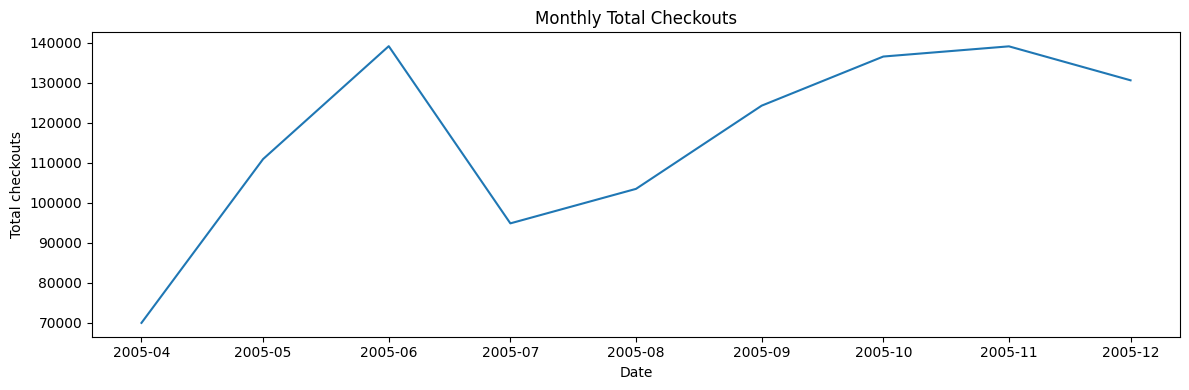

In [60]:
plt.figure(figsize=(12,4))  # Wide chart: easier to spot monthly ups and downs
plt.plot(monthly_total['date'], monthly_total['checkouts'])
plt.title("Monthly Total Checkouts")      # Clear title
plt.xlabel("Date")                        # Shows which month
plt.ylabel("Total checkouts")             # Shows number borrowed
plt.tight_layout()                        # Avoid label overlap
plt.show()

In [61]:
plt.savefig(os.path.join(OUT_DIR, 'monthly_total_checkouts.png'))
plt.close()
print(f"Saved monthly trend plot to {OUT_DIR}/monthly_total_checkouts.png")

Saved monthly trend plot to /content/drive/My Drive/U.C/I.T_PROJECT/Output_Dataset_improved/monthly_total_checkouts.png


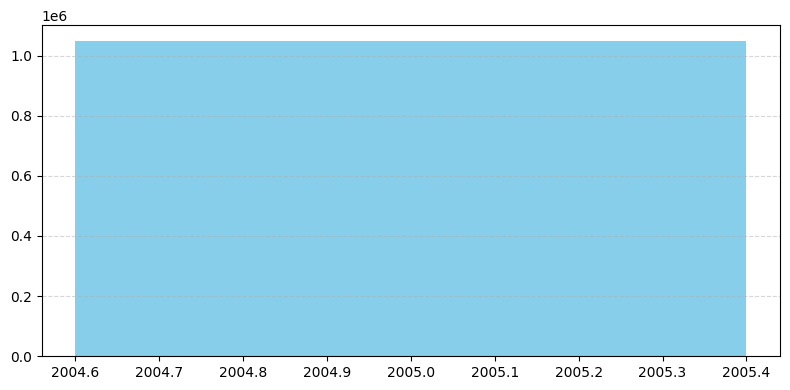

In [65]:
# === SECTION: YEARLY VISUALIZATION ===
# Why this matters:
# Technical: Yearly plotting smooths out noise, aiding in long-term planning and audit.
# Layman: Provides management a simple chart for annual reports—shows big picture changes over years.

yearly_total = group.groupby('year')['checkouts'].sum().reset_index()

plt.figure(figsize=(8,4))
plt.bar(yearly_total['year'], yearly_total['checkouts'], color='skyblue')
plt.grid(axis='y', linestyle='--', alpha=0.5)
plt.tight_layout()
plt.show()


In [70]:
type_rank = (
    group.groupby('itemtype')['checkouts']
         .sum()
         .sort_values(ascending=False)
         .reset_index()
)

top20 = type_rank.head(20)
top20.to_csv(os.path.join(OUT_DIR, 'itemtype_top20_most_used.csv'), index=False)

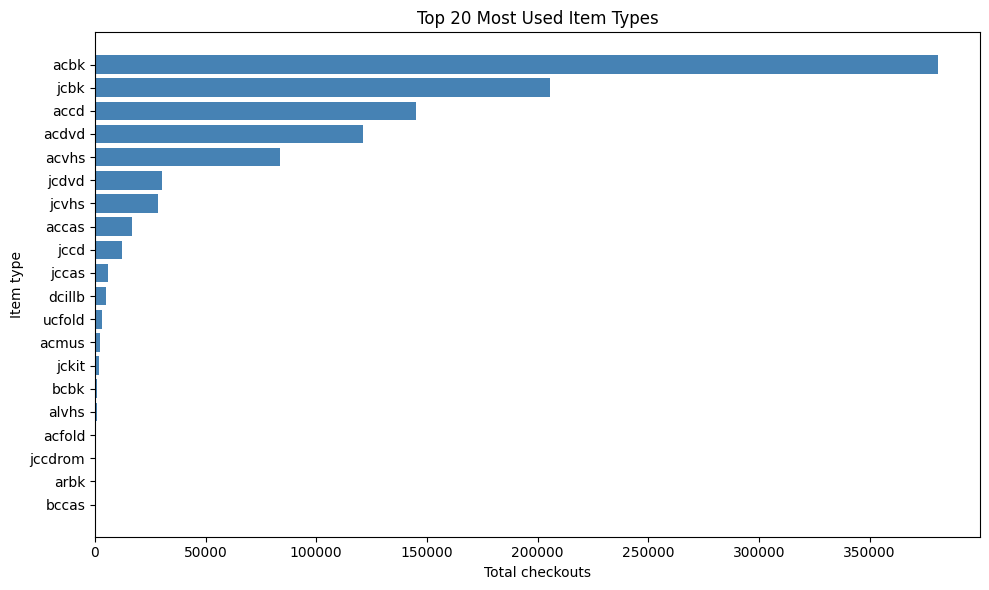

In [71]:
plt.figure(figsize=(10,6))
plt.barh(top20['itemtype'], top20['checkouts'], color='steelblue')
plt.gca().invert_yaxis()  # most-used at the top
plt.title("Top 20 Most Used Item Types")
plt.xlabel("Total checkouts")
plt.ylabel("Item type")
plt.tight_layout()
plt.show()
plt.savefig(os.path.join(OUT_DIR, 'itemtype_top20_most_used.png'))
plt.close()


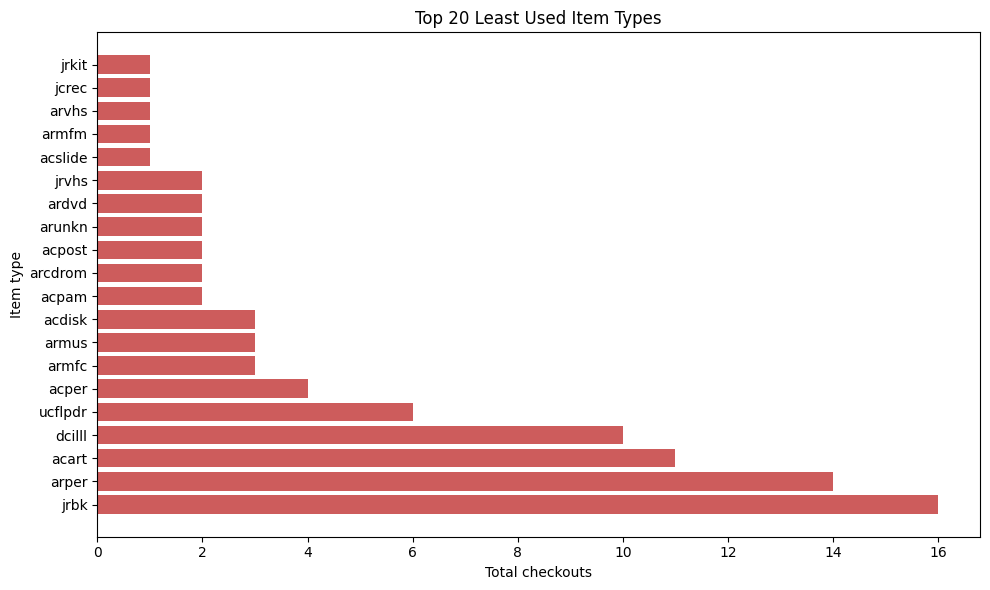

In [72]:
bottom20 = type_rank.tail(20).iloc[::-1]  # smallest at top of chart
bottom20.to_csv(os.path.join(OUT_DIR, 'itemtype_top20_least_used.csv'), index=False)

plt.figure(figsize=(10,6))
plt.barh(bottom20['itemtype'], bottom20['checkouts'], color='indianred')
plt.gca().invert_yaxis()
plt.title("Top 20 Least Used Item Types")
plt.xlabel("Total checkouts")
plt.ylabel("Item type")
plt.tight_layout()
plt.show()
plt.savefig(os.path.join(OUT_DIR, 'itemtype_top20_least_used.png'))
plt.close()


In [73]:
# Final message for users of all backgrounds
print(f"Saved outputs to {OUT_DIR}")

Saved outputs to /content/drive/My Drive/U.C/I.T_PROJECT/Output_Dataset_improved
